In [112]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torchinfo
from IPython.display import display_html
from scipy.special import softmax
from torchvision import transforms

from local_python.local_utils import (
    load_headless_model,
    load_dataloader,
    load_pd_from_json,
)
from ssl_library.src.models.fine_tuning.classifiers import LinearClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
seed = 19
checkpoint_path = (
    "../model_weights/vit_t16_v2/ViT_T16-ImageNet_1k_SSL_Dino_headless.pth"
)
dataset_path = "../datasets/HAM10000/images/split.csv"

In [31]:
loss_file_path = os.path.join(run_path, "loss.txt")
run_path = os.path.join(
    "../runs/",
    dataset_path.split("/")[2],
    os.path.splitext(os.path.basename(checkpoint_path))[0].replace("_headless", ""),
)
if not os.path.exists(run_path):
    os.makedirs(run_path)

In [3]:
assert torch.cuda.is_available()
n_devices = torch.cuda.device_count()
for i in range(0, n_devices):
    print(torch.cuda.get_device_name(i))

device = torch.device("cuda")

NVIDIA GeForce GTX 960


In [5]:
df_full = pd.read_csv(dataset_path)
assert "set" in df_full.columns.values, f"Available columns: {df_full.columns.values}"
assert (
    "target_code" in df_full.columns.values
), f"Available columns: {df_full.columns.values}"
classes = df_full["target_code"].unique()
num_classes = len(classes)

df_train = df_full[df_full["set"] == "train"]  # [:64]
print(f"Train size: {len(df_train)}")
assert num_classes == len(df_train["target_code"].unique())
dl_train = load_dataloader(df=df_train)

df_valid = df_full[df_full["set"] == "valid"]  # [:32]
print(f"Validation size: {len(df_valid)}")
assert num_classes == len(df_valid["target_code"].unique())
dl_valid = load_dataloader(df=df_valid)

# df_test = df_full[df_full["set"] == "test"]
# print(f"Test size: {len(df_test)}")

Train size: 8908
Validation size: 1103


In [126]:
label_map = {label: idx for idx, label in enumerate(classes)}
print(label_map)

{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


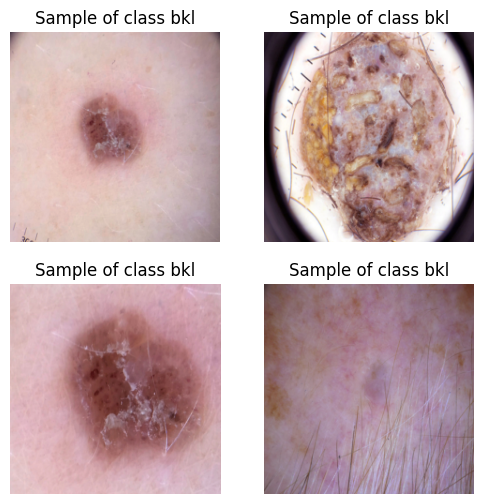

In [7]:
images, labels, sets = next(iter(dl_valid))

normalise_mean = (0.485, 0.456, 0.406)  # ImageNet
normalise_std = (0.229, 0.224, 0.225)  # ImageNet

number_of_rows = 2
number_of_columns = 2

fig, ax = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(3 * number_of_columns, 3 * number_of_rows),
    squeeze=False,
)

for i_col in range(number_of_columns):
    for i_row in range(number_of_rows):
        i = i_col * number_of_columns + i_row
        img = transforms.ToPILImage()(
            images[i].cpu() * torch.tensor(normalise_std)[:, None, None]
            + torch.tensor(normalise_mean)[:, None, None]
        )
        ax[i_row][i_col].axis("off")
        ax[i_row][i_col].imshow(img)
        ax[i_row][i_col].set_title(f"Sample of class {labels[i]}")

In [8]:
model = load_headless_model(checkpoint_path, use_ssl_library=True)
for param in model.parameters():
    param.requires_grad = False

summary = torchinfo.summary(model, images.shape[1:], batch_dim=0)
last_output = summary.summary_list[-1].output_size[-1]

model.head = LinearClassifier(
    last_output,
    num_labels=num_classes,
    use_dropout_in_head=True,
    large_head=False,
    use_bn=True,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()
torchinfo.summary(model, images.shape[1:], batch_dim=0)

Loading model with architecture 'vit_t16_v2' from ../model_weights/vit_t16_v2/ViT_T16-ImageNet_1k_SSL_Dino_headless.pth


Layer (type:depth-idx)                   Output Shape              Param #
ViTWrapper                               [1, 7]                    --
├─VisionTransformer: 1-1                 --                        38,016
│    └─PatchEmbed: 2-1                   [1, 192, 14, 14]          --
│    │    └─Conv2d: 3-1                  [1, 192, 14, 14]          (147,648)
│    └─Dropout: 2-2                      [1, 197, 192]             --
│    └─ModuleList: 2-9                   --                        (recursive)
│    │    └─Block: 3-2                   [1, 197, 192]             (444,864)
│    │    └─Block: 3-3                   [1, 197, 192]             (444,864)
│    │    └─Block: 3-4                   [1, 197, 192]             (444,864)
│    │    └─Block: 3-5                   [1, 197, 192]             (444,864)
│    │    └─Block: 3-6                   [1, 197, 192]             (444,864)
│    │    └─Block: 3-7                   [1, 197, 192]             (444,864)
│    │    └─Block: 3-8 

In [9]:
images, labels, sets = next(iter(dl_valid))

model = model.to(device)
model.eval()

images = images.to(device)
outputs = model(images)

label_tensor = torch.as_tensor([label_map[label] for label in labels])
label_tensor = label_tensor.to(device)

for output in outputs:
    probs = softmax(output.cpu().detach().numpy())
    max_idx = np.argmax(probs)
    print(f"category {max_idx} with probability {probs[max_idx]} ")

loss_function(outputs, label_tensor)

category 1 with probability 0.2829129695892334 
category 1 with probability 0.24304740130901337 
category 6 with probability 0.2739138901233673 
category 6 with probability 0.2963278889656067 
category 6 with probability 0.3837103545665741 
category 1 with probability 0.30900031328201294 
category 1 with probability 0.31243419647216797 
category 5 with probability 0.29431989789009094 
category 3 with probability 0.2949940860271454 
category 6 with probability 0.38663721084594727 
category 6 with probability 0.26530760526657104 
category 6 with probability 0.3142591118812561 
category 6 with probability 0.34411877393722534 
category 6 with probability 0.2978455722332001 
category 6 with probability 0.3257083594799042 
category 6 with probability 0.24048162996768951 


tensor(2.1811, device='cuda:0', grad_fn=<NllLossBackward0>)

In [10]:
def train_eval(
    model,
    optimizer,
    criterion,
    start_epoch,
    end_epoch,
    data_loader_train,
    data_loader_valid,
):
    model = model.to(device)
    model.train()
    for epoch in range(start_epoch, end_epoch):
        print(f"Start training epoch {epoch}")
        i = 0
        for images, targets, _ in data_loader_train:
            i += 1
            images = images.to(device)
            target_tensor = torch.as_tensor([label_map[target] for target in targets])
            target_tensor = target_tensor.to(device)
            outputs = model(images)
            loss = criterion(outputs, target_tensor)
            with open(loss_file_path, "a") as detaillog:
                line = {}
                line["epoch"] = epoch
                line["iteration"] = i
                line["loss"] = loss.item()
                line["set"] = "train"
                json.dump(line, detaillog, indent=2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        torch.save(
            model.state_dict(),
            os.path.join(run_path, f"checkpoint_{epoch}.pth"),
        )

        with torch.no_grad():
            i = 0
            for images, targets, _ in data_loader_valid:
                i += 1
                images = images.to(device)
                target_tensor = torch.as_tensor(
                    [label_map[target] for target in targets]
                )
                target_tensor = target_tensor.to(device)
                outputs = model(images)
                loss = criterion(outputs, target_tensor)
                with open(loss_file_path, "a") as detaillog:
                    line = {}
                    line["epoch"] = epoch
                    line["iteration"] = i
                    line["loss"] = loss.item()
                    line["set"] = "valid"
                    json.dump(line, detaillog, indent=2)

In [11]:
start_epoch = 0
end_epoch = 20

train_eval(model, optimizer, loss_function, start_epoch, end_epoch, dl_train, dl_valid)

Start training epoch 0
Start training epoch 1
Start training epoch 2
Start training epoch 3
Start training epoch 4
Start training epoch 5
Start training epoch 6
Start training epoch 7
Start training epoch 8
Start training epoch 9
Start training epoch 10
Start training epoch 11
Start training epoch 12
Start training epoch 13
Start training epoch 14
Start training epoch 15
Start training epoch 16
Start training epoch 17
Start training epoch 18
Start training epoch 19
Start training epoch 20
Start training epoch 21
Start training epoch 22
Start training epoch 23
Start training epoch 24
Start training epoch 25
Start training epoch 26
Start training epoch 27
Start training epoch 28
Start training epoch 29
Start training epoch 30
Start training epoch 31
Start training epoch 32
Start training epoch 33
Start training epoch 34
Start training epoch 35
Start training epoch 36
Start training epoch 37
Start training epoch 38
Start training epoch 39
Start training epoch 40
Start training epoch 41
St

In [113]:
def display_side_by_side(dfs, captions=[]):
    html_string = ""
    for i, df in enumerate(dfs):
        styler = df.style.set_table_attributes("style='display:inline'")
        if i < len(captions):
            styler.set_caption(captions[i])
        html_string += styler.to_html()
    display_html(html_string, raw=True)

In [115]:
df_metrics = load_pd_from_json(loss_file_path)
metric_columns = [
    column
    for column in df_metrics.columns.values
    if column not in ["epoch", "iteration", "set"]
]
df_metrics_valid = (
    df_metrics[df_metrics["set"] == "valid"]
    .groupby(["epoch"])[metric_columns]
    .mean(metric_columns)
)

n = 3
for metric_column in metric_columns:
    df_metrics_valid.sort_values(metric_column, inplace=True)
    display_side_by_side(
        [df_metrics_valid.head(n=n), df_metrics_valid.tail(n=n)],
        [
            f"{n} epochs with lowest validation {metric_column}:",
            f"{n} epochs with highest validation {metric_column}:",
        ],
    )

Read 62600 entries from loss.txt


,loss
epoch,
8,1.405540
9,1.433406
10,1.466912
,loss
epoch,
3,1.990405
1,2.116992
2,2.386391


In [117]:
best_epoch = df_metrics_valid["loss"].idxmin()
print(f"Best epoch by validation loss is {best_epoch}")

best_checkpoint = os.path.join(run_path, f"checkpoint_{best_epoch}.pth")
print(f"Loading {best_checkpoint}")
checkpoint = torch.load(best_checkpoint, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint, strict=True)

Best epoch by validation loss is 8
Loading ../runs/HAM10000\ViT_T16-ImageNet_1k_SSL_Dino\checkpoint_8.pth


<All keys matched successfully>

In [120]:
label_tensor = torch.zeros(0)
pred_tensor = torch.zeros(0)

with torch.no_grad():
    for images, targets, _ in dl_valid:
        target_tensor = torch.as_tensor([label_map[target] for target in targets])
        label_tensor = torch.cat([label_tensor, target_tensor])

        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        pred_tensor = torch.cat([pred_tensor, preds.view(-1).cpu()])

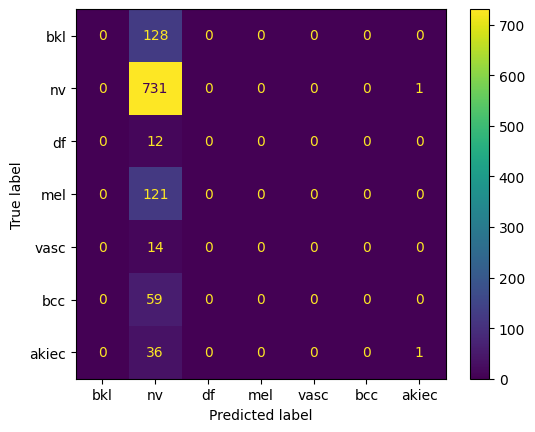

In [125]:
cm = confusion_matrix(label_tensor.numpy(), pred_tensor.numpy())
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm_display.plot()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()